#  Comparison of Segmentation Methods on X-ray Microtomography Data

This notebook evaluates and compares **five** segmentation approaches applied to X-ray Microtomography (Micro-CT) images:

1. **Standalone U-Net** – A convolutional encoder–decoder trained independently on labeled data.  
2. **Standalone Vision Transformer (ViT)** – A transformer-based model trained independently.  
3. **Cross-Teaching U-Net** – U-Net trained with mutual pseudo-labeling from ViT.
4. **Cross-Teaching ViT** – ViT trained with mutual pseudo-labeling from U-Net.
5. **Cross-Teaching Ensemble** – Combined prediction from cross-teaching trained models.

The goal is to benchmark these models on the same dataset, assess their segmentation quality using metrics such as Dice score and IoU, and determine whether cross-teaching improves performance over standalone training.

Imports

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
import timm
from skimage.filters import threshold_otsu
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
import sys

device = "cuda" if torch.cuda.is_available() else "cpu"
device

/Users/hoskuldurthorsteinsson/Documents/GitHub/Semi-supervised-Microtomography-Segmentation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

Load and Visualize Data

## Important Note on Image Loading

The X-ray micro-CT TIFF images are stored in 32-bit floating point format (PIL mode "F") with very small intensity values (typically in the range of 10⁻⁶ to 10⁻⁴).

**Key fix**: The `load_image()` function must NOT convert these float images to "L" (8-bit grayscale) mode, as this conversion will clip all values to 0. Instead, we directly convert to numpy arrays and preserve the float32 dtype, then apply min-max normalization to scale to [0, 1] range.

In [2]:

# ============================================================
#   Helper: Read image as grayscale float32 numpy array
# ============================================================
def load_image(path):
    img = Image.open(path)
    # Don't convert float images to 'L' mode as it will clip to [0,255]
    # Just convert directly to numpy array and ensure float32
    arr = np.array(img)
    # Handle different input types
    if arr.dtype == np.uint8:
        arr = arr.astype(np.float32) / 255.0  # Normalize uint8 to [0,1]
    elif arr.dtype == np.uint16:
        arr = arr.astype(np.float32) / 65535.0  # Normalize uint16 to [0,1]
    else:
        arr = arr.astype(np.float32)
    
    # If image has multiple channels, take the first channel or average
    if len(arr.shape) == 3:
        arr = arr[:, :, 0]  # Take first channel
    
    return arr


# ============================================================
#   Evaluation-only Dataset for X-ray Microtomography Segmentation
# ============================================================
class XrayMicroCTDataset(Dataset):
    """
    (This is reformatted from the Unet_TransferLearn.py script)
    Evaluation-only dataset:
        ✓ No augmentations
        ✓ No random operations
        ✓ Strictly deterministic
        ✓ Otsu thresholding for masks (optional)
        ✓ Fixed normalization (min-max or z-score)
        ✓ Returns image + mask as torch tensors

    Suitable for inference, visualization, and model comparison.
    """

    def __init__(
        self,
        image_dir,
        mask_dir=None,
        resize_to=512,
        normalize="minmax",   # "minmax", "zscore", or None
        use_otsu=True,
    ):
        # Get all file paths and filter out directories
        all_image_paths = sorted(glob(os.path.join(image_dir, "*")))
        self.image_paths = [p for p in all_image_paths if os.path.isfile(p)]
        
        if mask_dir:
            all_mask_paths = sorted(glob(os.path.join(mask_dir, "*")))
            self.mask_paths = [p for p in all_mask_paths if os.path.isfile(p)]
        else:
            self.mask_paths = None

        self.resize_to = resize_to
        self.normalize = normalize
        self.use_otsu = use_otsu

        assert len(self.image_paths) > 0, "No images found!"
        if self.mask_paths:
            assert len(self.image_paths) == len(self.mask_paths), \
                f"Image and mask count mismatch: {len(self.image_paths)} images vs {len(self.mask_paths)} masks"

    def __len__(self):
        return len(self.image_paths)

    def _resize(self, arr):
        """Resize using PIL with correct interpolation."""
        img = Image.fromarray(arr.astype(np.float32))
        img = img.resize((self.resize_to, self.resize_to), Image.BILINEAR)
        return np.array(img).astype(np.float32)

    def _normalize(self, arr):
        if self.normalize is None:
            return arr

        if self.normalize == "minmax":
            mn, mx = arr.min(), arr.max()
            if mx > mn:
                return (arr - mn) / (mx - mn)
            else:
                return arr * 0  # degenerate case

        if self.normalize == "zscore":
            mean = arr.mean()
            std = arr.std() + 1e-6
            return (arr - mean) / std

        return arr

    def __getitem__(self, idx):
        # -----------------------------
        # Load image
        # -----------------------------
        img = load_image(self.image_paths[idx])
        img = self._resize(img)
        img = self._normalize(img)

        # Convert to tensor: (1, H, W)
        img_t = torch.from_numpy(img).unsqueeze(0)

        # -----------------------------
        # Load mask (if exists)
        # -----------------------------
        if self.mask_paths is not None:
            mask = load_image(self.mask_paths[idx])

            mask = mask.astype(np.float32)
            mask = self._resize(mask)

            # Optional: Otsu threshold for clean segmentation targets
            if self.use_otsu:
                t = threshold_otsu(mask)
                mask = (mask > t).astype(np.float32)
            else:
                mask = (mask > 0.5).astype(np.float32)

            mask_t = torch.from_numpy(mask).unsqueeze(0)
        else:
            mask_t = None

        return img_t, mask_t, os.path.basename(self.image_paths[idx])


In [3]:
# ============================================================
#   Visualization Helpers
# ============================================================

def show_image(img_tensor, title="Image"):
    img = img_tensor.squeeze().cpu().numpy()
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


def show_image_and_mask(img, mask, filename=""):
    img = img.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()

    plt.figure(figsize=(10,4))
    plt.suptitle(filename)

    plt.subplot(1,2,1)
    plt.imshow(img, cmap="gray")
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask (binary)")
    plt.axis("off")
    plt.show()


def compare_predictions(img, mask, unet_pred, vit_pred, ensemble_pred, filename=""):
    """Side-by-side comparison for evaluation notebook."""
    img  = img.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    u    = unet_pred.squeeze().cpu().numpy()
    v    = vit_pred.squeeze().cpu().numpy()
    e    = ensemble_pred.squeeze().cpu().numpy()

    plt.figure(figsize=(16,6))
    plt.suptitle(f"Segmentation Comparison – {filename}", fontsize=14)

    titles = [
        "Input Image",
        "Ground Truth Mask",
        "U-Net Prediction",
        "ViT Prediction",
        "Ensemble Output",
    ]
    arrays = [img, mask, u, v, e]

    for i, (arr, t) in enumerate(zip(arrays, titles)):
        plt.subplot(1, 5, i+1)
        plt.imshow(arr, cmap="gray")
        plt.title(t)
        plt.axis("off")

    plt.show()


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_DIR = "Data/Original Images"           # ⚠️ UPDATE ME
MASK_DIR  = "Data/Original Masks"            # ⚠️ UPDATE ME

dataset = XrayMicroCTDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    resize_to=512,
    normalize="minmax",
    use_otsu=True
)



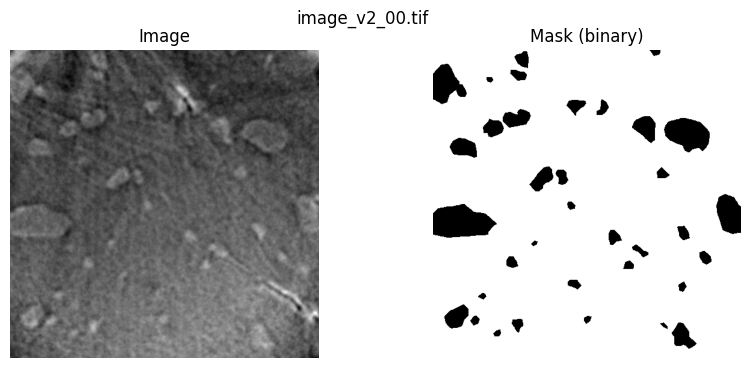

In [5]:
img, mask, fname = dataset[0]
show_image_and_mask(img, mask, fname)

Load in Models and Model Architectures

In [6]:
# -----------------------------
# Vision Transformer Segmentation Head
# -----------------------------
from pathlib import Path
from timm import create_model


class ViTSegmentationHead(nn.Module):
    def __init__(self, embed_dim=1024, num_classes=1):
        super().__init__()
        # Use BatchNorm2d instead of LayerNorm for 4D tensors
        self.norm = nn.BatchNorm2d(embed_dim)
        self.conv = nn.Conv2d(embed_dim, num_classes, kernel_size=1)

    def forward(self, features):
        normed = self.norm(features)
        seg_map = self.conv(normed)
        seg_map = torch.sigmoid(seg_map)
        return seg_map

# -----------------------------
# Vision Transformer Segmentation Model
# -----------------------------
class ViTSegmentation(nn.Module):
    def __init__(self, num_classes=1, img_size=224):
        super().__init__()

        self.vit = create_model(
            'vit_large_patch16_224',
            pretrained=True,
            img_size=img_size,
            in_chans=1,
            num_classes=0
        )
        for param in self.vit.parameters():
            param.requires_grad = False

        embed_dim = self.vit.embed_dim
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, embed_dim, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )
        self.seg_head = ViTSegmentationHead(embed_dim=embed_dim, num_classes=num_classes)

    def forward(self, x):
        vit_out = self.vit.forward_features(x)
        b, num_tokens, embed = vit_out.shape
        
        # Calculate the actual spatial dimensions
        # ViT has class token + patch tokens, so subtract 1 for class token
        num_patches = num_tokens - 1
        side = int(num_patches ** 0.5)
        
        # Remove class token (first token) and reshape
        patch_tokens = vit_out[:, 1:, :]  # Skip class token
        feat_2d = patch_tokens.transpose(1, 2).reshape(b, embed, side, side)
        
        upsampled = self.decoder(feat_2d)
        seg_map = self.seg_head(upsampled)
        return seg_map

    def load_vit_weights(self, path):
        """Load ViT weights from either .pth (PyTorch) or .npz (NumPy) format."""
        path_str = str(path)
        
        if path_str.endswith('.npz'):
            # NumPy format
            state_dict = np.load(path)['params']
            self.load_state_dict(state_dict, strict=False)
        elif path_str.endswith('.pth'):
            # PyTorch format
            checkpoint = torch.load(path, map_location='cpu')
            
            # Handle different checkpoint formats
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    state_dict = checkpoint['model_state_dict']
                elif 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                else:
                    state_dict = checkpoint
            else:
                state_dict = checkpoint
            
            self.load_state_dict(state_dict, strict=False)
        else:
            raise ValueError(f"Unsupported file format: {path_str}. Expected .pth or .npz")
        
        print(f"Loaded custom ViT weights from {path}")


# -----------------------------
# U-Net Loader Function
# -----------------------------
def load_unet_model(unet_path: str, device: str = "cuda"):
    
    if not Path(unet_path).exists():
        raise FileNotFoundError(f"U-Net model file not found at: {unet_path}")

    checkpoint = torch.load(unet_path, map_location=device)

    # Try loading with segmentation_models_pytorch first (if that's what was used for training)
    try:
        import segmentation_models_pytorch as smp
        unet_model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2
        )
        
    except ImportError:
        # Fallback to custom U-Net from Model directory
        sys.path.insert(0, "Model")
        from unet_pytorch import create_unet_for_porosity
        unet_model = create_unet_for_porosity(input_size=(512, 512), device=device)
        

    # Extract and load state dict
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        state_dict = checkpoint["model_state_dict"]
    elif isinstance(checkpoint, dict) and "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    elif isinstance(checkpoint, dict):
        state_dict = checkpoint
    else:
        raise ValueError("Unexpected checkpoint format")

    unet_model.load_state_dict(state_dict, strict=False)
    unet_model.to(device)
    unet_model.eval()
    
    return unet_model


# -----------------------------
# Cross Teaching Trainer (for ensemble inference)
# -----------------------------
class CrossTeachingTrainer:
    def __init__(self, unet, vit, device="cuda"):
        self.unet = unet.eval()
        self.vit = vit.eval()
        self.device = device

    @torch.no_grad()
    def ensemble_predict(self, images):
        images = images.to(self.device)

        unet_in = F.interpolate(images, size=(512, 512), mode="bilinear", align_corners=False)
        vit_in = F.interpolate(images, size=(224, 224), mode="bilinear", align_corners=False)

        unet_pred = self.unet(unet_in)
        vit_pred = self.vit(vit_in)
        
        # Handle multi-class U-Net output
        if unet_pred.shape[1] == 2:
            unet_pred = torch.softmax(unet_pred, dim=1)[:, 1:2, :, :]

        unet_pred_up = F.interpolate(unet_pred, size=images.shape[-2:], mode="bilinear", align_corners=False)
        vit_pred_up = F.interpolate(vit_pred, size=images.shape[-2:], mode="bilinear", align_corners=False)

        return (unet_pred_up + vit_pred_up) / 2
    
    def eval(self):
        """For compatibility with evaluation function."""
        return self

#Metric for segmentation performance
def dice_score(pred, target, eps=1e-6):
    pred_bin = (pred > 0.5).float()
    target_bin = (target > 0.5).float()
    intersection = (pred_bin * target_bin).sum()
    return (2 * intersection) / (pred_bin.sum() + target_bin.sum() + eps)


In [7]:
UNET_PATH = "checkpoints/unet_porosity_model_pytorch.pth"     
VIT_PRETRAIN = "checkpoints/vit_porosity_model_pytorch.pth"       
XUNET_PATH = "Model/unet_epoch_30.pth"     
XVIT_PRETRAIN = "Model/vit_epoch_30.pth"       

# ==========================================
# Load Standalone Models
# ==========================================
print("Loading Standalone Models...")
unet = load_unet_model(UNET_PATH, device=DEVICE)
vit = ViTSegmentation().to(DEVICE)
vit.load_vit_weights(VIT_PRETRAIN)

# ==========================================
# Load Cross-Teaching Models
# ==========================================
print("Loading Cross-Teaching Models...")
Xunet = load_unet_model(XUNET_PATH, device=DEVICE)
Xvit = ViTSegmentation().to(DEVICE)
Xvit.load_vit_weights(XVIT_PRETRAIN)

# ==========================================
# Create Ensembles
# ==========================================
print("Creating Ensembles...")
ensemble_standalone = CrossTeachingTrainer(unet, vit, device=DEVICE)
ensemble_crossteach = CrossTeachingTrainer(Xunet, Xvit, device=DEVICE)

print("\n✓ All models loaded successfully!")

Loading Standalone Models...
Loaded custom ViT weights from checkpoints/vit_porosity_model_pytorch.pth
Loading Cross-Teaching Models...
Loaded custom ViT weights from Model/vit_epoch_30.pth
Creating Ensembles...

✓ All models loaded successfully!


Inference Helpers

In [8]:
@torch.no_grad()
def predict_unet(unet, image_tensor, device="cuda"):
    image_resized = F.interpolate(image_tensor, size=(512, 512),
                                  mode="bilinear", align_corners=False)
    pred = unet(image_resized)
    
    # Handle multi-class output (take channel 1 or apply softmax)
    if pred.shape[1] == 2:
        # If 2 classes, take the positive class (index 1) or apply softmax
        pred = torch.softmax(pred, dim=1)[:, 1:2, :, :]  # Keep dim for interpolation
    elif pred.shape[1] > 1:
        # For more than 2 classes, take argmax or first channel
        pred = pred[:, 0:1, :, :]
    
    pred = F.interpolate(pred, size=image_tensor.shape[-2:],
                         mode="bilinear", align_corners=False)
    return pred


@torch.no_grad()
def predict_vit(vit, image_tensor, device="cuda"):
    image_resized = F.interpolate(image_tensor, size=(224, 224),
                                  mode="bilinear", align_corners=False)
    pred = vit(image_resized)
    pred = F.interpolate(pred, size=image_tensor.shape[-2:],
                         mode="bilinear", align_corners=False)
    return pred


Visualize

Generating predictions for: image_v2_00.tif


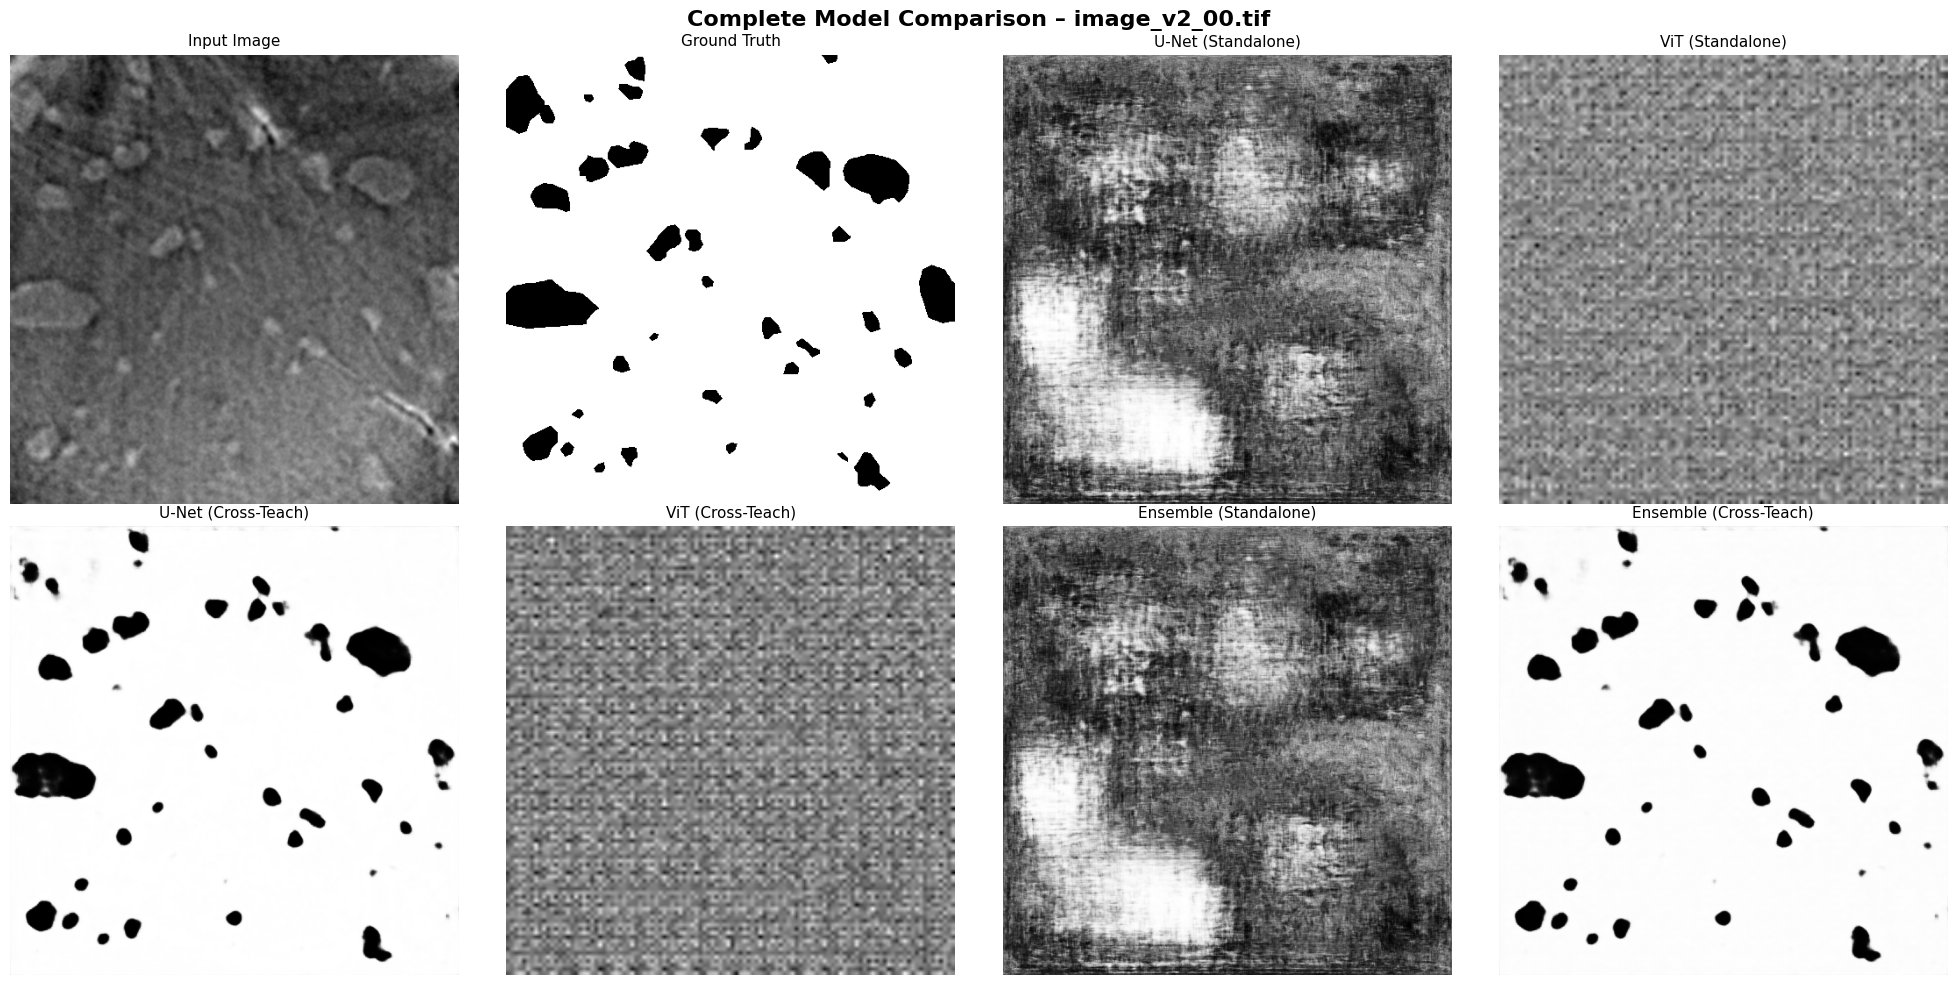

In [9]:
def visualize_all_predictions(image, mask, unet_pred, vit_pred, xunet_pred, xvit_pred, 
                              ens_standalone_pred, ens_crossteach_pred, filename=""):
    """Visualize all model predictions side-by-side."""
    image = image.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    
    predictions = {
        "Input Image": image,
        "Ground Truth": mask,
        "U-Net (Standalone)": unet_pred.squeeze().cpu().numpy(),
        "ViT (Standalone)": vit_pred.squeeze().cpu().numpy(),
        "U-Net (Cross-Teach)": xunet_pred.squeeze().cpu().numpy(),
        "ViT (Cross-Teach)": xvit_pred.squeeze().cpu().numpy(),
        "Ensemble (Standalone)": ens_standalone_pred.squeeze().cpu().numpy(),
        "Ensemble (Cross-Teach)": ens_crossteach_pred.squeeze().cpu().numpy(),
    }
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f"Complete Model Comparison – {filename}", fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    for idx, (title, img_data) in enumerate(predictions.items()):
        axes[idx].imshow(img_data, cmap="gray")
        axes[idx].set_title(title, fontsize=11)
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.show()


# ==========================================
# Generate predictions from all models
# ==========================================
idx = 0
image, mask, fname = dataset[idx]

image_tensor = image.unsqueeze(0).to(DEVICE)
mask_tensor = mask.unsqueeze(0).to(DEVICE)

print(f"Generating predictions for: {fname}")

# Standalone models
unet_pred = predict_unet(unet, image_tensor, device=DEVICE)
vit_pred = predict_vit(vit, image_tensor, device=DEVICE)

# Cross-teaching models
xunet_pred = predict_unet(Xunet, image_tensor, device=DEVICE)
xvit_pred = predict_vit(Xvit, image_tensor, device=DEVICE)

# Ensembles
ens_standalone_pred = ensemble_standalone.ensemble_predict(image_tensor)
ens_crossteach_pred = ensemble_crossteach.ensemble_predict(image_tensor)

# Visualize all
visualize_all_predictions(
    image_tensor,
    mask_tensor,
    unet_pred,
    vit_pred,
    xunet_pred,
    xvit_pred,
    ens_standalone_pred,
    ens_crossteach_pred,
    filename=fname
)

Evaluations

In [10]:
# -----------------------------
# Metric utilities
# -----------------------------

def dice_score(pred, target):
    """Compute Dice score for binary segmentation."""
    pred = pred.flatten()
    target = target.flatten()

    intersection = (pred * target).sum()
    return (2 * intersection) / (pred.sum() + target.sum() + 1e-6)


def iou_score(pred, target):
    """Compute Intersection-over-Union."""
    pred = pred.flatten()
    target = target.flatten()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-6)


def precision_recall(pred, target):
    """Compute precision and recall using TP, FP, FN."""
    pred = pred.flatten()
    target = target.flatten()

    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    fn = ((1 - pred) * target).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return precision, recall


# -----------------------------
# Enhanced Evaluation Function
# -----------------------------

def evaluate_all_models(dataset, unet, vit, xunet, xvit, 
                        ensemble_standalone, ensemble_crossteach, device="cuda"):
    """
    Evaluate all 5 models: standalone U-Net, standalone ViT, 
    cross-teaching U-Net, cross-teaching ViT, and cross-teaching ensemble.
    
    Returns comprehensive metrics (Dice, IoU, Precision, Recall) for each model.
    """

    # Metric accumulators
    metrics = {
        "U-Net (Standalone)": {"dice": [], "iou": [], "prec": [], "rec": []},
        "ViT (Standalone)": {"dice": [], "iou": [], "prec": [], "rec": []},
        "U-Net (Cross-Teach)": {"dice": [], "iou": [], "prec": [], "rec": []},
        "ViT (Cross-Teach)": {"dice": [], "iou": [], "prec": [], "rec": []},
        "Ensemble (Cross-Teach)": {"dice": [], "iou": [], "prec": [], "rec": []},
    }

    # Set all models to eval mode
    unet.eval()
    vit.eval()
    xunet.eval()
    xvit.eval()
    ensemble_standalone.eval()
    ensemble_crossteach.eval()

    # -------------------------
    # Main evaluation loop
    # -------------------------
    print("Evaluating models on dataset...")
    with torch.no_grad():
        for img_t, mask_t, fname in dataset:
            # Move to device
            img = img_t.to(device).unsqueeze(0)
            mask = mask_t.to(device).unsqueeze(0)
            target = (mask > 0.5).float()

            # ---- Get predictions from all models ----
            pred_unet = (predict_unet(unet, img) > 0.5).float()
            pred_vit = (predict_vit(vit, img) > 0.5).float()
            pred_xunet = (predict_unet(xunet, img) > 0.5).float()
            pred_xvit = (predict_vit(xvit, img) > 0.5).float()
            pred_ens_cross = (ensemble_crossteach.ensemble_predict(img) > 0.5).float()

            # ---- Compute metrics for each model ----
            for name, pred in [
                ("U-Net (Standalone)", pred_unet),
                ("ViT (Standalone)", pred_vit),
                ("U-Net (Cross-Teach)", pred_xunet),
                ("ViT (Cross-Teach)", pred_xvit),
                ("Ensemble (Cross-Teach)", pred_ens_cross),
            ]:
                d = dice_score(pred.cpu().numpy(), target.cpu().numpy())
                i = iou_score(pred.cpu().numpy(), target.cpu().numpy())
                p, r = precision_recall(pred.cpu().numpy(), target.cpu().numpy())

                metrics[name]["dice"].append(d)
                metrics[name]["iou"].append(i)
                metrics[name]["prec"].append(p)
                metrics[name]["rec"].append(r)

    # -------------------------
    # Create summary table
    # -------------------------
    summary = pd.DataFrame({
        "Model": list(metrics.keys()),
        "Dice": [np.mean(metrics[m]["dice"]) for m in metrics],
        "IoU": [np.mean(metrics[m]["iou"]) for m in metrics],
        "Precision": [np.mean(metrics[m]["prec"]) for m in metrics],
        "Recall": [np.mean(metrics[m]["rec"]) for m in metrics],
    })
    
    # Sort by Dice score (descending)
    summary = summary.sort_values("Dice", ascending=False).reset_index(drop=True)

    print("\n" + "="*60)
    print("   SEGMENTATION PERFORMANCE SUMMARY")
    print("="*60)
    display(summary.style.set_caption("Complete Model Comparison on X-ray Micro-CT Segmentation")
            .background_gradient(cmap='RdYlGn', subset=['Dice', 'IoU', 'Precision', 'Recall']))

    return summary

In [11]:
summary = evaluate_all_models(
    dataset,
    unet,
    vit,
    Xunet,
    Xvit,
    ensemble_standalone,
    ensemble_crossteach,
    device=DEVICE
)

# Display key findings
print("\n" + "="*60)
print("   KEY FINDINGS")
print("="*60)
best_model = summary.iloc[0]["Model"]
best_dice = summary.iloc[0]["Dice"]
print(f"🏆 Best Model: {best_model}")
print(f"   Dice Score: {best_dice:.4f}")

# Compare cross-teaching vs standalone
standalone_dice = summary[summary["Model"].str.contains("Standalone")]["Dice"].mean()
crossteach_dice = summary[summary["Model"].str.contains("Cross-Teach")]["Dice"].mean()
improvement = ((crossteach_dice - standalone_dice) / standalone_dice) * 100

print(f"\n📊 Cross-Teaching vs Standalone:")
print(f"   Standalone Average Dice: {standalone_dice:.4f}")
print(f"   Cross-Teaching Average Dice: {crossteach_dice:.4f}")
print(f"   Improvement: {improvement:+.2f}%")

Evaluating models on dataset...

   SEGMENTATION PERFORMANCE SUMMARY


,Model,Dice,IoU,Precision,Recall
0,U-Net (Cross-Teach),0.969721,0.941409,0.948212,0.992529
1,Ensemble (Cross-Teach),0.969701,0.941372,0.948144,0.992561
2,ViT (Standalone),0.941969,0.890394,0.890409,0.999980
3,ViT (Cross-Teach),0.940578,0.887914,0.890444,0.996800
4,U-Net (Standalone),0.487096,0.324141,0.845365,0.345092



   KEY FINDINGS
🏆 Best Model: U-Net (Cross-Teach)
   Dice Score: 0.9697

📊 Cross-Teaching vs Standalone:
   Standalone Average Dice: 0.7145
   Cross-Teaching Average Dice: 0.9600
   Improvement: +34.35%
